# 自己训练的水果分类模型-单张图像

通过Python API方式，使用torchcam算法库，对自己训练的水果图像分类模型进行基于CAM的可解释性分析。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-8-19

## 设置matplotlib中文字体

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [4]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [3]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体

'wget' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


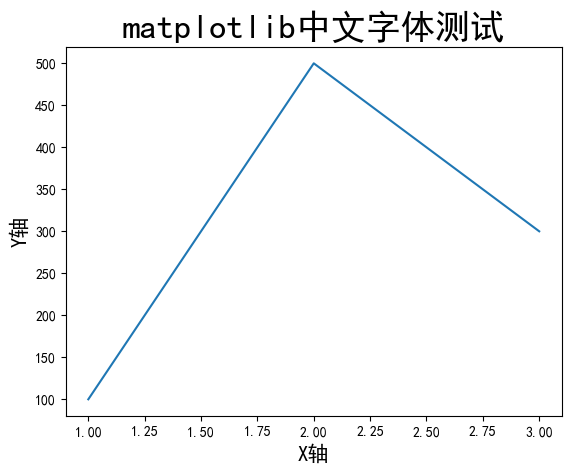

In [4]:
plt.plot([1,2,3], [100,500,300])
plt.title('matplotlib中文字体测试', fontsize=25)
plt.xlabel('X轴', fontsize=15)
plt.ylabel('Y轴', fontsize=15)
plt.show()

## 导入工具包

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from PIL import Image

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 导入训练好的Pytorch模型

In [21]:
model = torch.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\checkpoint\best-0.986.pth')
model = model.eval().to(device)

## 导入可解释性分析方法

In [26]:
import torchcam
from torchcam.methods import GradCAMpp
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

cam_extractor = GradCAMpp(model)

RuntimeError: cannot register a hook on a tensor that doesn't require gradient

## 预处理

In [7]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

D:\Software\anaconda\envs\Pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 运行图像分类预测

In [8]:
img_path = r"D:\dataset\Parasitized\C39P4thinF_original_IMG_20150622_105102_cell_83_RCAN_BIX4-official.png"

In [9]:
img_pil = Image.open(img_path)
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理

In [10]:
pred_logits = model(input_tensor)
pred_id = torch.topk(pred_logits, 1)[1].detach().cpu().numpy().squeeze().item()

NameError: name 'model' is not defined

In [13]:
pred_id

0

## 生成可解释性分析热力图

In [14]:
activation_map = cam_extractor(pred_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()

In [15]:
activation_map.shape

(7, 7)

## 可视化

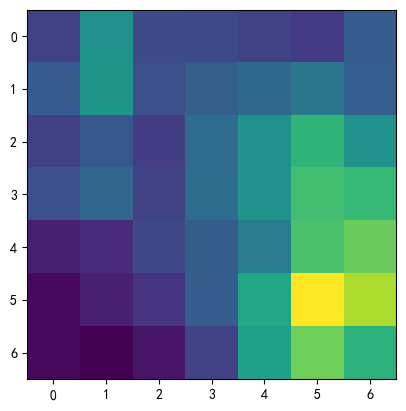

In [16]:
plt.imshow(activation_map)
plt.show()

In [17]:
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7)

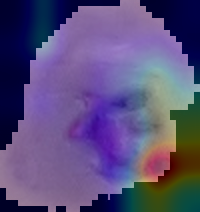

In [18]:
result

## 载入类别名称和索引号映射字典

In [19]:
idx_to_labels = np.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\idx_to_labels.npy', allow_pickle=True).item()
labels_to_idx = np.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\labels_to_idx.npy', allow_pickle=True).item()

In [20]:
idx_to_labels

{0: 'parasitized', 1: 'uninfected'}

In [21]:
labels_to_idx

{'parasitized': 0, 'uninfected': 1}

## 整理代码

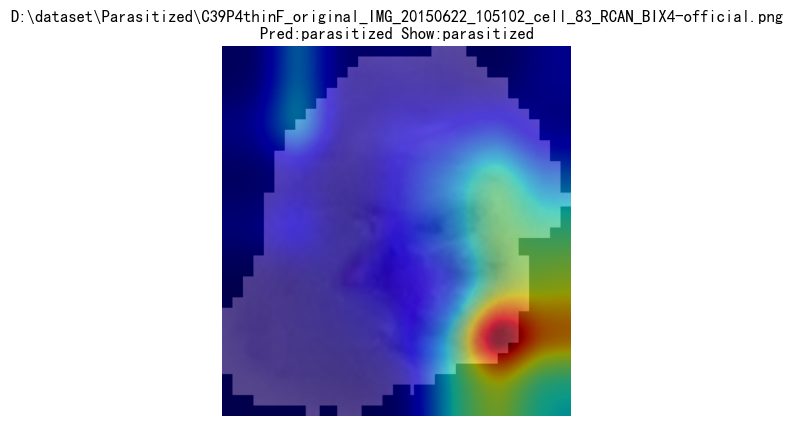

In [23]:
img_path = r"D:\dataset\Parasitized\C39P4thinF_original_IMG_20150622_105102_cell_83_RCAN_BIX4-official.png"

# 可视化热力图的类别，如果不指定，则为置信度最高的预测类别
show_class = 'parasitized'

# 前向预测
img_pil = Image.open(img_path)
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
pred_logits = model(input_tensor)
pred_id = torch.topk(pred_logits, 1)[1].detach().cpu().numpy().squeeze().item()

if show_class:
    class_id = labels_to_idx[show_class]
    show_id = class_id
else:
    show_id = pred_id

# 获取热力图
activation_map = cam_extractor(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.4)
plt.imshow(result)
plt.axis('off')

plt.title('{}\nPred:{} Show:{}'.format(img_path, idx_to_labels[pred_id], show_class))
plt.show()